# Instalacion de librerias necesarias

In [37]:
!pip install tensorflow
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Obtencion y visualizacion de datos

Se utilizara para la predicion, el indice Nino 1+2
![Título de la imagen](https://bobtisdale.wordpress.com/wp-content/uploads/2015/11/figure-1.png)


## Obtencion de datos del indice Nino 1+2 EXCEL

Lectura del archivo excel que tiene los indice **iNCE**

In [1]:
import pandas as pd
import numpy as np

path_excel = 'C:/Users/yerso/OneDrive/Escritorio/archivo/Clasificacion indice ICEN.xlsx'

df = pd.read_excel(path_excel, sheet_name='Niño 1+2 (Anomaly)')

print(df)

         fecha   Anomalia  Unnamed: 2   Unnamed: 3   Unnamed: 4   Unnamed: 5  \
0   1958-01-01       0.14           n   800.000000          NaN          1.0   
1   1958-02-01       0.26         max     4.470000          NaN          2.0   
2   1958-03-01       0.48         min    -2.670000          NaN          3.0   
3   1958-04-01       0.71       rango     7.140000          NaN          4.0   
4   1958-05-01       0.12           k    10.580197         11.0          5.0   
..         ...        ...         ...          ...          ...          ...   
795 2024-04-01      -0.21         NaN          NaN          NaN          NaN   
796 2024-05-01      -1.17         NaN          NaN          NaN          NaN   
797 2024-06-01      -0.95         NaN          NaN          NaN          NaN   
798 2024-07-01      -0.79         NaN          NaN          NaN          NaN   
799 2024-08-01      -0.46         NaN          NaN          NaN          NaN   

        -2.67   Unnamed: 7   Unnamed: 8

In [2]:
print(df['fecha'][:5])

df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')

print("\n","="*100,"\n")
print(df['fecha'][:5])


0   1958-01-01
1   1958-02-01
2   1958-03-01
3   1958-04-01
4   1958-05-01
Name: fecha, dtype: datetime64[ns]


0   1958-01-01
1   1958-02-01
2   1958-03-01
3   1958-04-01
4   1958-05-01
Name: fecha, dtype: datetime64[ns]


In [3]:
df = df[['fecha', 'Anomalia']]

y_train = df[df['fecha'] <= '2016-12-31']
y_validation = df[df['fecha'] >= '2017-01-01']

y_train = y_train['Anomalia'].to_numpy()
y_validation  = y_validation['Anomalia'].to_numpy()

print(y_train.shape, y_validation.shape)

(708,) (92,)


## Obtener los datos para de entrenamiento

In [4]:
import numpy as np
import os

path = 'OneDrive/Escritorio'
sst_train = np.load(path + "/archivo/Entrenamiento_sin_nan.npy")
sst_valid =  np.load(path + "/archivo/Validacion_sin_nan.npy")

nino_train = y_train
nino_valid = y_validation

print(sst_train.shape, nino_train.shape)
print(sst_valid.shape, nino_valid.shape)
print(sst_train.min(), nino_train.min())
print(sst_train.max(), nino_train.max())


(708, 100, 120) (708,)
(92, 100, 120) (92,)
-1.9397346 -2.67
36.437675 4.47


## Funcion de concatenacion de dato y Agrupacion

**Parámetros:**
* **path:** Dirección donde se encuentra la carpeta de los archivo
* **long_data:** Cantidad de datos que se va a analizar
 
**Return:**
  *  Dato ya concatenado, de acuero a **long_data**

In [5]:

def cargar_data( sst, nino1_2, long_data=3, long_pred=12):
    
    sst_data, nino1_2_data = [], []

    data_aux_1, data_aux_2  = [], []

    # agrupa 3 capas en la variable data_aux_1
    for i in range(long_data):
        # calcular el index ultimo, tomando encuenta log data, y log predict
        j = i-(long_data + long_pred - 1)

        sst_data = sst[i:j][:, :, :, np.newaxis]
        
        data_aux_1.append(sst_data)  
        
    for i in range(long_pred):
        #calcula el index, con la cantida que se va a predecir xd
        index_end = i - (long_pred -1)
        j = index_end if index_end != 0 else None
        nino1_2_data = nino1_2[i+long_data:j][:, np.newaxis]
        data_aux_2.append(nino1_2_data)
        
    sst_data = np.concatenate(data_aux_1, axis=3)
    nino1_2_data = np.concatenate(data_aux_2, axis=1)
    
    return sst_data, nino1_2_data

In [6]:
sst_train, nino_train = cargar_data(sst_train, nino_train)
sst_valid, nino_valid = cargar_data(sst_valid, nino_valid)

print(sst_train.shape, nino_train.shape)
print(sst_valid.shape, nino_valid.shape)

(694, 100, 120, 3) (694, 12)
(78, 100, 120, 3) (78, 12)


## Normalizar datos

Preparar los datos, sacando el promedio y la desviacion estandar
Z-core

In [7]:
sst_mean = sst_train.mean()
nino_mean = nino_train.mean()

sst_std = sst_train.std()
nino_std = nino_train.std()

print("promedio: ", sst_mean, nino_mean)
print("desviacion estandar: ", sst_std, nino_std)

promedio:  12.754112 -0.21850024015369834
desviacion estandar:  11.1031685 1.0916539311867322


**Normalizar los datos de entrenamiento**

In [8]:
# Normalizar los datos (centrar y escalar)
sst_data_normalized = (sst_train - sst_mean) / sst_std
nino_data_normalized = (nino_train - nino_mean) / nino_std

sst_train, nino_train = sst_data_normalized, nino_data_normalized

print(sst_train.shape, nino_train.shape)

print(sst_train.min(), nino_train.min())
print(sst_train.max(), nino_train.max())

(694, 100, 120, 3) (694, 12)
-1.3233922 -2.2456748332150345
2.1330454 4.2948594845042605


In [9]:
# Normalizar los datos (centrar y escalar)
sst_data_normalized = (sst_valid - sst_mean) / sst_std
nino_data_normalized = (nino_valid - nino_mean) / nino_std

sst_valid, nino_valid = sst_data_normalized, nino_data_normalized

print(sst_valid.shape, nino_valid.shape)

(78, 100, 120, 3) (78, 12)


# Creacion del Modelo

Las **CNN** son modelos ampliamentes utilizados para identificar patrones en datos estructurados, como imagenes y matrices, lo cual es fundamental para realizar predicciones en cierto problemas. La capacidad predictiva de las **CNN** se bas en sus capass convolucionales, donde cada capa utiliza filtros para detectar caracteristicas locales.  En problemas predictivos, como en la predicción de fenómenos climáticos, las CNN aprenden de datos históricos etiquetados y ajustan sus parámetros mediante un proceso supervisado, de modo que identifican las características espaciales y temporales que predicen mejor el comportamiento futuro. 

Para predecir El Niño 1+2, se utilizarán redes neuronales convolucionales **(CNN)** que procesarán matrices de datos con tres canales: los meses anteriores (n-0, n-1, n-2). Estos canales representan las temperaturas del océano **SST**.

![Diferencia](C:/Users/yerso/OneDrive/Escritorio/canales.png)

## ARQUITECTURA DEL MODELO CNN

![Diferencia](C:/Users/yerso/OneDrive/Escritorio/ArquitecturaModelo.png)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, PReLU, LeakyReLU, ELU
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle

In [19]:
model = Sequential([
    Conv2D(32, (5,6), activation='tanh',padding="same", input_shape=sst_train.shape[1:]),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (5, 6), activation='tanh', padding="same"),
    MaxPooling2D((2, 2)),

    Conv2D(32, (5, 6), activation='tanh', padding="same"),
    MaxPooling2D((2, 2)),
    
    Flatten(),

    Dense(60),
    Dropout(0.4),

    
    Dense(60, activation='tanh'),
    Dropout(0.4), 
    
    Dense(12)
])

model.summary()

C:\Users\yerso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 100, 120, 32)        │           2,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 60, 32)          │          30,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 30, 32)          │          30,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 60)                  │         345,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 60)                  │           3,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │             732 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 414,468 (1.58 MB)

 Trainable params: 414,468 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [30]:
history_list = {"loss":[],"val_loss":[]}

model.compile(optimizer=SGD(), loss="mse")

for i in range(1):
    input_train, y_train = shuffle(sst_train, nino_train)   
    history = model.fit(input_train, y_train,validation_data=(sst_valid, nino_valid), epochs=10, batch_size=100)
    history_list["loss"] += history.history['loss']
    history_list["val_loss"] += history.history['val_loss']
    
    print("\n","="*100,"\n")

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.8772 - val_loss: 3.3394
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 2.4092 - val_loss: 0.9118
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.8421 - val_loss: 0.9122
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.6129 - val_loss: 0.8217
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.5598 - val_loss: 0.8446
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.6005 - val_loss: 0.8956
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.5709 - val_loss: 0.8168
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.5409 - val_loss: 0.8278
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.5298 - val_loss: 0.8772
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.5408 - val_loss: 0.7872




# Resultado final( graficamente xd)

In [31]:
pre_nino = model.predict(sst_valid )
pre_nino.shape, nino_valid.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


((78, 12), (78, 12))

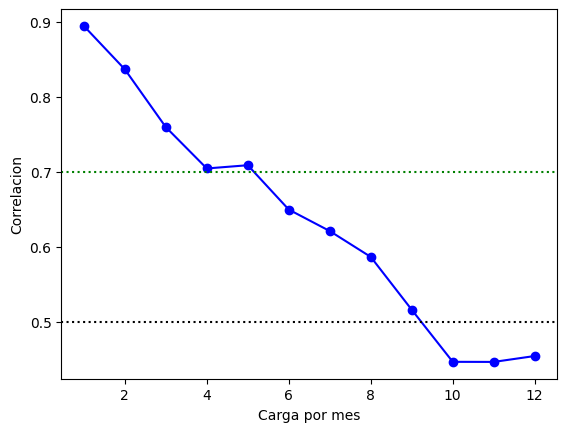

In [32]:
import scipy.stats as sts
import matplotlib.pyplot as plt

corr_ls = []
for i in range(12):
    corr, _ = sts.pearsonr(pre_nino[:,i], nino_valid[:,i])
    corr_ls.append(corr)
plt.plot(np.arange(1, 13), corr_ls, "o-", color="blue")
plt.xlabel("Carga por mes")
plt.ylabel("Correlacion")
plt.axhline(0.7, color="g", linestyle=":")

plt.axhline(0.5, color="k", linestyle=":")

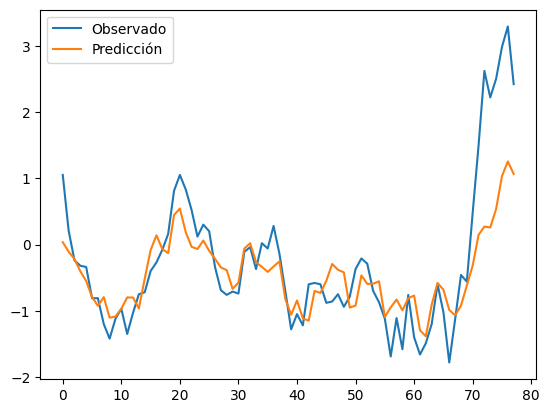

[ 1.05  0.21 -0.24 -0.32 -0.34 -0.81 -0.81 -1.2  -1.42 -1.12 -0.97 -1.35
 -1.03 -0.75 -0.72 -0.4  -0.27 -0.08  0.16  0.81  1.05  0.83  0.52  0.12
  0.3   0.2  -0.34 -0.69 -0.76 -0.71 -0.74 -0.11 -0.04 -0.37  0.02 -0.06
  0.28 -0.14 -0.7  -1.28 -1.05 -1.22 -0.6  -0.58 -0.6  -0.88 -0.86 -0.75
 -0.94 -0.79 -0.37 -0.21 -0.29 -0.7  -0.87 -1.12 -1.69 -1.11 -1.58 -0.76
 -1.4  -1.66 -1.49 -1.2  -0.6  -1.02 -1.78 -1.13 -0.46 -0.56  0.48  1.49
  2.62  2.22  2.5   2.98  3.29  2.42]
[ 0.03523774 -0.10817485 -0.21875256 -0.40337557 -0.55126446 -0.79245156
 -0.9251675  -0.79416984 -1.1033169  -1.0876348  -0.9704211  -0.79786634
 -0.8010256  -0.9656037  -0.5130388  -0.08452696  0.13900216 -0.06921044
 -0.13023365  0.44444573  0.54309857  0.18655957 -0.03465188 -0.06817073
  0.05980317 -0.09492333 -0.21541777 -0.34558427 -0.38753206 -0.6691356
 -0.57423985 -0.06152748  0.01929012 -0.2666329  -0.3368798  -0.4136206
 -0.33220965 -0.25411245 -0.82153296 -1.0595555  -0.8446283  -1.115171
 -1.1489571  -0.7

In [33]:
salto_mes = 1
mes_mas_1 = 0
# Graficar ninno34_val
plt.plot(nino_valid[::salto_mes, mes_mas_1]  * nino_std + nino_mean, label="Observado")

# Graficar pre_nino
plt.plot(pre_nino[::salto_mes, mes_mas_1]  * nino_std + nino_mean, label="Predicción")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

print(nino_valid[::salto_mes, mes_mas_1] * nino_std + nino_mean)
print(pre_nino[::salto_mes, mes_mas_1]  * nino_std + nino_mean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


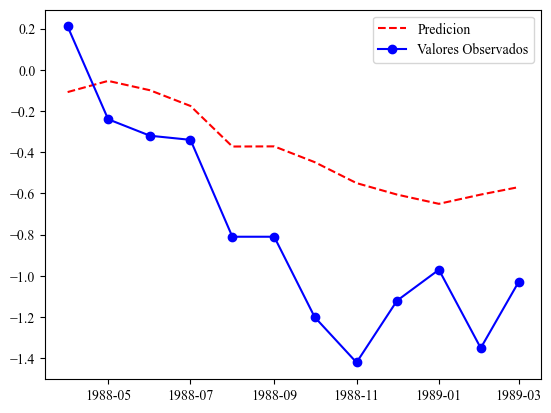

In [34]:
import pandas as pd
index_num = 1
pre_nino = model.predict(sst_valid[[index_num]] )
pre_nino = pre_nino  * nino_std + nino_mean
xd = nino_valid[index_num]
xd = xd  * nino_std + nino_mean
plt.rc('font', family='Times New Roman')
time0 = pd.date_range("1988-04-01","1989-03-15",freq="MS")

plt.plot(time0,pre_nino[0],"--",color="red",label="Predicion")


plt.plot(time0,xd,"o-",color="blue",label="Valores Observados")


plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


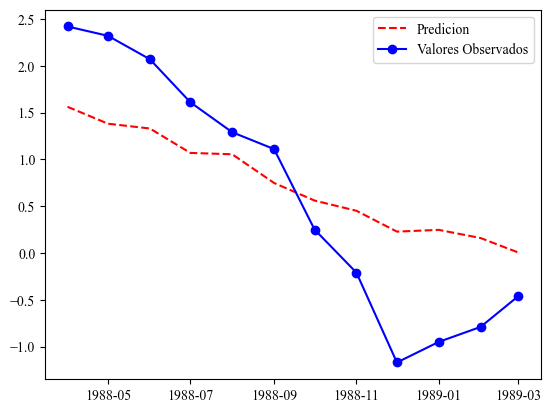

In [58]:
import pandas as pd
index_num = 77
pre_nino = model.predict(sst_valid[[index_num]] )
pre_nino = pre_nino  * nino_std + nino_mean
xd = nino_valid[index_num]
xd = xd  * nino_std + nino_mean
plt.rc('font', family='Times New Roman')
time0 = pd.date_range("1988-04-01","1989-03-15",freq="MS")

plt.plot(time0,pre_nino[0],"--",color="red",label="Predicion")


plt.plot(time0,xd,"o-",color="blue",label="Valores Observados")


plt.legend()

# Liberar memoria

In [ ]:
import gc
gc.collect()
exit()
